In [1]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('ggplot')
# import seaborn as sns
# sns.set_style("white")

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, Lambda, BatchNormalization
from tensorflow import cast, uint32, where
import keras
import keras.backend as K
import tensorflow as tf
import random
from PIL import Image
from tqdm import tqdm_notebook

In [2]:
import os

In [3]:
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

In [4]:
img_size_ori = 500
img_size_target = 256

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return img.resize((img_size_target, img_size_target), Image.ANTIALIAS)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
# def downsample(img):
#     if img_size_ori == img_size_target:
#         return img
#     return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
#     #return img[:img_size_ori, :img_size_ori]

In [5]:
out = os.listdir("TIFF black")
out.sort()
inp = os.listdir("TIFF 8bit")
inp.sort()
N = len(out)
out_data = np.zeros((N, 256, 256))
in_data = np.zeros((N,256,256))
print(N)

for i in range(N):
    out_data[i] = upsample(load_img(r"TIFF black/"+out[i], color_mode='grayscale'))
for i in range(N):
    in_data[i] = upsample(load_img(r"TIFF 8bit/"+inp[i], color_mode='grayscale'))
    
    
#plt.imshow(in_data[0])
        

2569


In [6]:
out_data = np.array(out_data)/255
inp_data = np.array(in_data)/255

In [7]:
x_train, x_test, y_train, y_test = train_test_split(in_data.reshape(-1, img_size_target, img_size_target, 1), 
    out_data.reshape(-1, img_size_target, img_size_target, 1),  test_size=0.2)

In [8]:
#x_train = (lambda x(x_train)
#x_test = (lambda x: 1.0*(x>0.02))(x_test)
y_train = (lambda x: (x>0.03).astype(int))(y_train)
y_test =(lambda x: (x>0.03).astype(int))(y_test)

print(np.unique(y_train), np.unique(y_test))


[0 1] [0 1]


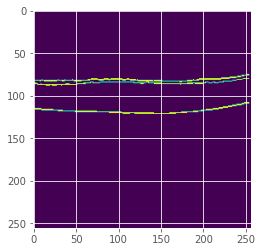

In [9]:
plt.imshow(y_train[100])

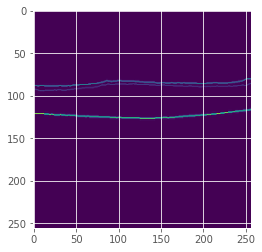

In [10]:
plt.imshow(out_data[150])

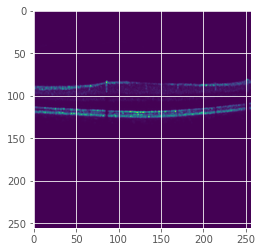

In [11]:
plt.imshow(inp_data[150])

In [12]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.25)(pool3)
    
    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.25)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(pool4)
    convm = BatchNormalization()(convm)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same", kernel_initializer = 'he_normal')(convm)
    convm = BatchNormalization()(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.25)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.25)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
#     output_layer = Lambda(lambda x : cast(x, uint32))(output_layer)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)

2022-05-06 03:53:48.321097: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-06 03:53:51.058263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 28105 MB memory:  -> device: 0, name: Tesla V100-SXM3-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2022-05-06 03:53:51.060821: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 28141 MB memory:  -> device: 1, name: Tesla V100-SXM3-32GB, pci bus id: 0000:57:00.0, compute capability: 7.0
2022-05-06 03:53:51.064274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:

In [13]:
def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.25)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.25)(pool3)
    
    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.25)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(pool4)
    convm = BatchNormalization()(convm)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same", kernel_initializer = 'uniform')(convm)
    convm = BatchNormalization()(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.25)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = BatchNormalization()(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.25)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = BatchNormalization()(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
#     output_layer = Lambda(lambda x : cast(x, uint32))(output_layer)
    
    return output_layer


In [14]:
def recall(A,B):
    return ((A & B).sum()+1)/(A.sum()+1)

def precision(A,B):
    return ((B&A).sum()+1)/(B.sum()+1)

def f1(A,B):
    p = precision(A,B)
    r = recall(A,B)
    return 2*p*r/(p+r)

In [15]:
A = np.array([[1,0,1],[1,1,1],[0,1,0]])
B = np.array([[0,0,0],[0,0,0],[0,0,0]])

print(A & B)
print(precision(A,B))
print(recall(A,B))
# print()

[[0 0 0]
 [0 0 0]
 [0 0 0]]
1.0
0.14285714285714285


In [16]:
from tensorflow.keras.metrics import Precision, Recall, MeanIoU, Accuracy
from tensorflow.keras.losses import BinaryCrossentropy

In [17]:
def weightedBinCrossEntr(positive_weight=15):
    def f(y_true, y_pred, w = positive_weight):
        y_true = cast(y_true, tf.float32)
        weights = tf.ones_like(y_pred)  # (None,512,512,1)
        weights = tf.where(y_pred > 0.5, w * weights, weights)
        out = keras.losses.binary_crossentropy(y_true, y_pred)  # (None,512,512)
        out = K.expand_dims(out, axis=-1) * weights  # (None,512,512,1)* (None,512,512,1)
        return K.mean(out)
    return f

In [18]:
def diceLoss():  
    def f(targets, inputs, smooth=1e-6):
        inputs = K.flatten(inputs)
        targets = cast(K.flatten(targets), tf.float32)

        intersection = K.sum(tf.multiply(targets, inputs))
        dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
        return 1 - dice
    return f

def weightedDiceLoss(weight_ratio=4):
    def f(targets, inputs, smooth=1e-6, weight_ratio = weight_ratio):
        weights = tf.ones_like(targets)  # (None,512,512,1)
        weights = tf.where(inputs > 0.5, weight_ratio * weights, weights)
        out = diceLoss()(targets, inputs)  # (None,512,512)
        out = K.expand_dims(out, axis=-1) * cast(weights, tf.float32)  # (None,512,512,1)* (None,512,512,1)
        return K.mean(out)
    return f

In [19]:
def DiceBCE():
    def f(targets, inputs, smooth=1e-6):
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        targets=cast(targets,tf.float32)
        print(inputs[:10])
        print(targets[:10])
        BCE =  keras.losses.binary_crossentropy(targets, inputs)
        intersection = K.sum(tf.multiply(cast(targets,tf.float32), cast(inputs, tf.float32)))  
        dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
        Dice_BCE = BCE + dice_loss

        return Dice_BCE
    return f

In [20]:
def IoULoss():
    def f(targets, inputs, smooth=1e-6):
        inputs = K.flatten(inputs)
        targets = cast(K.flatten(targets), tf.float32)

        intersection = K.sum(tf.multiply(targets, inputs))
        total = K.sum(targets) + K.sum(inputs)
        union = total - intersection

        IoU = (intersection + smooth) / (union + smooth)
        return 1 - IoU
    return f

In [21]:
models = {}




# Model(input_layer, output_layer) for x in range(20)
input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)
models["BCE"]=[0,Model(input_layer, output_layer)]


for i in [3,10, 17, 25, 40]:
    input_layer = Input((img_size_target, img_size_target,1))
    output_layer = build_model(input_layer, 20)
    models["wBCE-"+str(i)]=[i, Model(input_layer, output_layer)]

input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)
models["diceLoss"] = [0,Model(input_layer, output_layer)]


for i in [3,10, 17, 25, 40]:
    input_layer = Input((img_size_target, img_size_target,1))
    output_layer = build_model(input_layer, 20)
    models["wDice-"+str(i)]=[i, Model(input_layer, output_layer)]

    
input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)
models["DiceBCE"] = [0,Model(input_layer, output_layer)]
    
    
input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)
models["IoULoss"]=[0, Model(input_layer, output_layer)]


weighteds=["wBCE", "wDice"]
functions = {   "BCE": BinaryCrossentropy,
                "wBCE": weightedBinCrossEntr,
                "diceLoss": diceLoss,
                "wDice": weightedDiceLoss,
                "DiceBCE": DiceBCE,
                "IoULoss":IoULoss
            }

histories = {}

In [22]:
for loss in models.keys():
    if models[loss][0]!=0:
        f = functions[loss.split('-')[0]](models[loss][0])
    else:
        f = functions[loss]()    
    models[loss][1].compile(loss=f, optimizer="adam", metrics=[Recall(),Precision(),
                                                                    MeanIoU(num_classes=2), "accuracy", "AUC"])
    

    early_stopping = EarlyStopping(patience=10, verbose=1)
    model_checkpoint = ModelCheckpoint(f"./iter_{loss}.model", save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

    epochs = 200
    batch_size = 32

    histories[loss] =  models[loss][1].fit(x_train, y_train,
                        validation_data=[x_test, y_test], 
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, model_checkpoint, reduce_lr])
    
    fname = "f"
    
    print(f"\n\n {fname}    {f}\n\n\n\n")
    model = load_model(f'./iter_{loss}.model', custom_objects={fname:f})
    del models[loss][1]



Epoch 1/200


2022-05-06 03:54:04.177268: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


65/65 [==============================] - ETA: 0s - loss: 0.5789 - recall: 0.8483 - precision: 0.1233 - mean_io_u: 0.5387 - accuracy: 0.8886 - auc: 0.8977
Epoch 1: val_loss improved from inf to 0.46644, saving model to ./iter_BCE.model


2022-05-06 03:54:23.545670: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./iter_BCE.model/assets
65/65 [==============================] - 28s 333ms/step - loss: 0.5789 - recall: 0.8483 - precision: 0.1233 - mean_io_u: 0.5387 - accuracy: 0.8886 - auc: 0.8977 - val_loss: 0.4664 - val_recall: 0.5250 - val_precision: 0.3213 - val_mean_io_u: 0.4910 - val_accuracy: 0.9714 - val_auc: 0.8667 - lr: 0.0010
Epoch 2/200
64/65 [============================>.] - ETA: 0s - loss: 0.3166 - recall: 0.8290 - precision: 0.6205 - mean_io_u: 0.6993 - accuracy: 0.9878 - auc: 0.9519
Epoch 2: val_loss improved from 0.46644 to 0.14346, saving model to ./iter_BCE.model
INFO:tensorflow:Assets written to: ./iter_BCE.model/assets
65/65 [==============================] - 19s 297ms/step - loss: 0.3163 - recall: 0.8287 - precision: 0.6209 - mean_io_u: 0.6993 - accuracy: 0.9878 - auc: 0.9518 - val_loss: 0.1435 - val_recall: 0.2451 - val_precision: 0.8578 - val_mean_io_u: 0.4953 - val_accuracy: 0.9857 - val_auc: 0.8786 - lr: 0.0010
Epoch 3/200
64/65 [======

In [46]:
dir(histories['BCE'])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_implements_predict_batch_hooks',
 '_implements_test_batch_hooks',
 '_implements_train_batch_hooks',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_supports_tf_logs',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [81]:
type(histories["BCE"].history)

dict

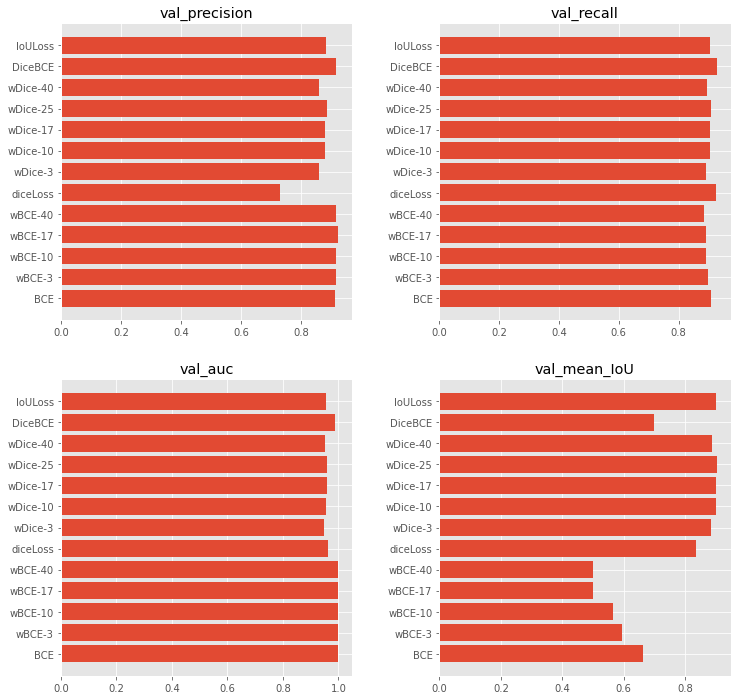

In [132]:
names = list(histories.keys())

argmaxindices = []
precisions = []
recall = []
auc = []
mean_io_u = []


for name in names:
    metrics = histories[name].history.keys()
    argmaxindices.append((tf.argmin(histories[name].history["val_loss"])).numpy())
    for metric in metrics:
        if metric.startswith("precision"):
            precisions.append(histories[name].history[metric][argmaxindices[-1]])
        elif metric.startswith("recall"):
            recall.append(histories[name].history[metric][argmaxindices[-1]])
        elif metric.startswith("auc"):
            auc.append(histories[name].history[metric][argmaxindices[-1]])
        elif metric.startswith("mean_io_u"):
            mean_io_u.append(histories[name].history[metric][argmaxindices[-1]])
        

fig, ((ax00, ax01),(ax10,ax11)) = plt.subplots(2,2, figsize=(12,12))
ax00.set_title("val_precision")
ax00.barh(names[:4]+names[5:], precisions[:4]+precisions[5:])

ax01.set_title("val_recall")
ax01.barh(names[:4]+names[5:], recall[:4]+recall[5:])

ax10.set_title("val_auc")
ax10.barh(names[:4]+names[5:], auc[:4]+auc[5:])

ax11.set_title("val_mean_IoU")
ax11.barh(names[:4]+names[5:], mean_io_u[:4]+mean_io_u[5:])

# fig.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.2)
fig.savefig("my_fig.jpeg")



 f    <keras.losses.BinaryCrossentropy object at 0x7f0101773760>






 f    <function weightedBinCrossEntr.<locals>.f at 0x7f010c411d30>






 f    <function weightedBinCrossEntr.<locals>.f at 0x7f00d807f040>






 f    <function weightedBinCrossEntr.<locals>.f at 0x7f01019f6af0>






 f    <function weightedBinCrossEntr.<locals>.f at 0x7f01842f4940>






 f    <function weightedBinCrossEntr.<locals>.f at 0x7f013027d8b0>






 f    <function diceLoss.<locals>.f at 0x7f00dbd439d0>






 f    <function weightedDiceLoss.<locals>.f at 0x7f01303f4700>






 f    <function weightedDiceLoss.<locals>.f at 0x7f01306744c0>






 f    <function weightedDiceLoss.<locals>.f at 0x7f01306635e0>






 f    <function weightedDiceLoss.<locals>.f at 0x7f00d819d430>






 f    <function weightedDiceLoss.<locals>.f at 0x7f0101b2a310>






 f    <function DiceBCE.<locals>.f at 0x7f0184432040>






 f    <function IoULoss.<locals>.f at 0x7f01841efee0>






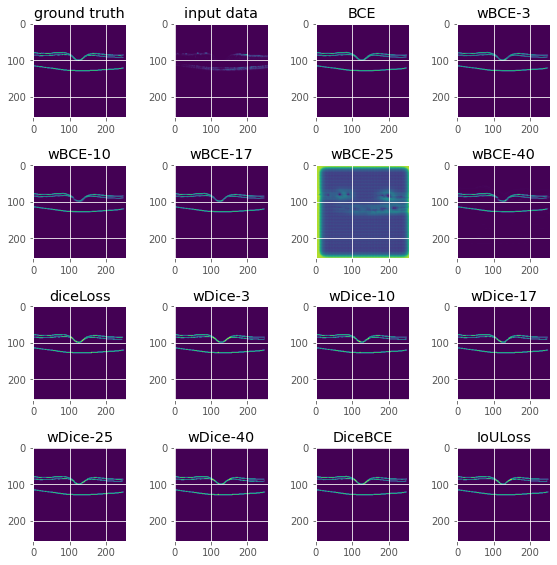

In [148]:
t = 14
y_sample = y_test[t].reshape(256,256)

fig, [[a01,a02,a03,a04],[a11,a12,a13,a14], [a21,a22,a23,a24], [a31,a32,a33,a34]] = plt.subplots(4,4, figsize=(8,8))
fig.tight_layout()


axs = [[a01,a02,a03,a04],[a11,a12,a13,a14], [a21,a22,a23,a24], [a31,a32,a33,a34]] 

a01.imshow(y_sample)
a01.set_title("ground truth")

a02.imshow(x_test[t].reshape(256,256))
a02.set_title("input data")

i=0
j=2
for loss in models.keys():
    if models[loss][0]!=0:
        f = functions[loss.split('-')[0]](models[loss][0])
    else:
        f = functions[loss]()  
    
    fname = "f"
    
    print(f"\n\n {fname}    {f}\n\n\n\n")
    model = load_model(f'./iter_{loss}.model', custom_objects={fname:f})
    
    
    predicted = model.predict(x_test)
    axs[i][j].imshow(predicted[t].squeeze())
    axs[i][j].set_title(loss)
    j = (j+1)%4
    if j==0: i+=1

        
fig.savefig("predictions.jpeg")

In [151]:
names = list(histories.keys())

argmaxindices = []
precisions = []
recall = []
auc = []
mean_io_u = []


for name in names:
    metrics = histories[name].history.keys()
    argmaxindices.append((tf.argmin(histories[name].history["val_loss"])).numpy())
    for metric in metrics:
        if metric.startswith("precision"):
            precisions.append(histories[name].history[metric][argmaxindices[-1]])
        elif metric.startswith("recall"):
            recall.append(histories[name].history[metric][argmaxindices[-1]])
        elif metric.startswith("auc"):
            auc.append(histories[name].history[metric][argmaxindices[-1]])
        elif metric.startswith("mean_io_u"):
            mean_io_u.append(histories[name].history[metric][argmaxindices[-1]])

l = []
for i in range(len(names)):
    l.append([])
    l[-1].append(names[i])
    l[-1].append(precisions[i])
    l[-1].append(recall[i])
    l[-1].append(auc[i])
    l[-1].append(mean_io_u[i])
table = tabulate(l, headers=['Loss', 'Precision', 'Recall', "AUC", "Mean IoU"], tablefmt='orgtbl')
print(table)

| Loss     |   Precision |   Recall |      AUC |   Mean IoU |
|----------+-------------+----------+----------+------------|
| BCE      |    0.91409  | 0.907954 | 0.999263 |   0.661571 |
| wBCE-3   |    0.918204 | 0.899749 | 0.999312 |   0.594243 |
| wBCE-10  |    0.915452 | 0.890431 | 0.999037 |   0.563584 |
| wBCE-17  |    0.924417 | 0.891063 | 0.99896  |   0.498943 |
| wBCE-25  |    0.095021 | 0.48759  | 0.578404 |   0.491814 |
| wBCE-40  |    0.917349 | 0.883703 | 0.998537 |   0.501471 |
| diceLoss |    0.729209 | 0.923778 | 0.963287 |   0.836579 |
| wDice-3  |    0.860186 | 0.890365 | 0.948928 |   0.884593 |
| wDice-10 |    0.881486 | 0.906755 | 0.956349 |   0.899613 |
| wDice-17 |    0.881792 | 0.906569 | 0.957259 |   0.899269 |
| wDice-25 |    0.88779  | 0.90858  | 0.958364 |   0.902758 |
| wDice-40 |    0.86201  | 0.894641 | 0.950092 |   0.887416 |
| DiceBCE  |    0.915831 | 0.927456 | 0.989068 |   0.697196 |
| IoULoss  |    0.884173 | 0.905075 | 0.955582 |   0.899912 |


In [149]:
from tabulate import tabulate

In [24]:
np.array([1.0,1.0,2.0]).astype(int)

array([1, 1, 2])

In [25]:
x_train[0].shape

(256, 256, 1)

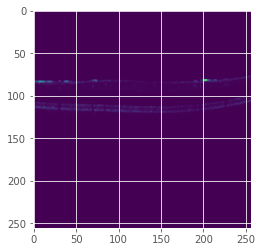

In [26]:
plt.imshow(x_train[100].reshape(256,256))

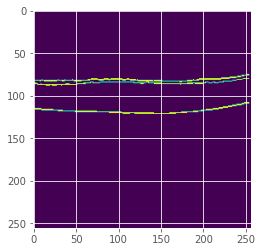

In [27]:
plt.imshow(y_train[100].squeeze())

In [28]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./w4testBCE2D.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 5
batch_size = 32

# weights = {0:0.1, 1:1}

history = model.fit(x_train, y_train,
                    validation_data=[x_test, y_test], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])

Epoch 1/5
64/65 [============================>.] - ETA: 0s - loss: 0.1891 - recall_13: 0.9057 - precision_13: 0.8859 - mean_io_u_13: 0.9008 - accuracy: 0.9962 - auc: 0.9559
Epoch 1: val_loss improved from inf to 0.34025, saving model to ./w4testBCE2D.model
INFO:tensorflow:Assets written to: ./w4testBCE2D.model/assets
65/65 [==============================] - 27s 368ms/step - loss: 0.1893 - recall_13: 0.9056 - precision_13: 0.8858 - mean_io_u_13: 0.9007 - accuracy: 0.9962 - auc: 0.9559 - val_loss: 0.3403 - val_recall_13: 0.7390 - val_precision_13: 0.8605 - val_mean_io_u_13: 0.8222 - val_accuracy: 0.9931 - val_auc: 0.8730 - lr: 1.0000e-04
Epoch 2/5
65/65 [==============================] - ETA: 0s - loss: 0.1892 - recall_13: 0.9060 - precision_13: 0.8856 - mean_io_u_13: 0.9007 - accuracy: 0.9962 - auc: 0.9560
Epoch 2: val_loss did not improve from 0.34025
65/65 [==============================] - 14s 211ms/step - loss: 0.1892 - recall_13: 0.9060 - precision_13: 0.8856 - mean_io_u_13: 0.9007

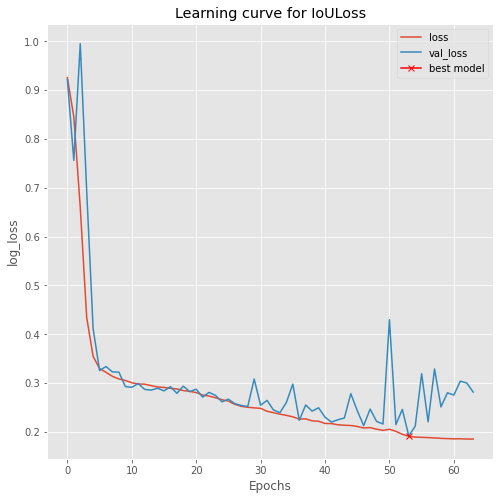

In [159]:
history = histories["IoULoss"]

plt.figure(figsize=(8, 8))
plt.title("Learning curve for IoULoss")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
history = histories["IoULoss"]


for name in history.keys():
    if name.startswith("precision"):
        precisions = history[name]
    elif name.startswith("recall"):
        recalls = history[name]

plt.figure(figsize=(8, 8))
plt.title("Learning curve for IoULoss")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

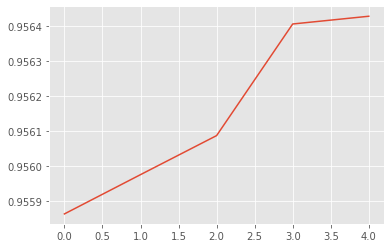

In [30]:
plt.plot(history.history["auc"], label="loss")

In [166]:
model = load_model('./w15BCE2D.model', custom_objects={"weightedBinCrossEntr":weightedBinCrossEntr})
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 256, 256, 20  200         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_36 (BatchN  (None, 256, 256, 20  80         ['conv2d_38[0][0]']              
 ormalization)                  )                                                           

In [32]:
predicteds = model.predict(x_test)
#plt.imshow(predicteds[0].reshape(1,512,512,1))


In [33]:
predicteds.shape

(514, 256, 256, 1)

In [34]:
print(float(Precision()(y_test,predicteds)), float(Recall()(y_test,predicteds)))



0.9347866773605347 0.912050187587738


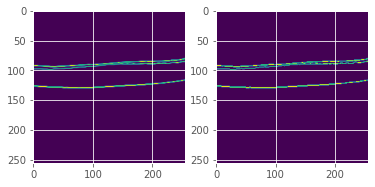

In [35]:
ax, p = plt.subplots(1,2)
i=23
p[0].imshow(predicteds[i].squeeze())
p[1].imshow(y_test[i].squeeze())

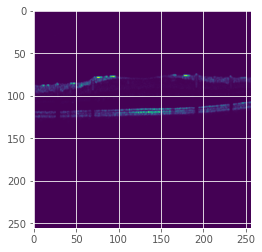

In [36]:
plt.imshow(x_test[0].reshape(256,256))

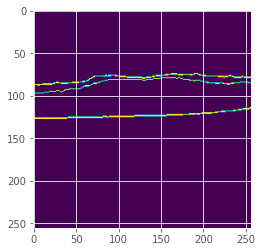

In [37]:
plt.imshow(y_test[0].reshape(256,256))

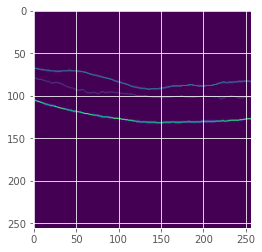

In [38]:
plt.imshow(out_data[0])

In [165]:
import pickle
with open("historiesfile.txt", "wb") as fh:
    pickle.dump(histories, fh)

INFO:tensorflow:Assets written to: ram://d5cea107-ea09-49c1-9235-867af2f808b7/assets
INFO:tensorflow:Assets written to: ram://dfbf6e24-2868-4b5c-94c2-8085cde4bdca/assets
INFO:tensorflow:Assets written to: ram://b5c34dc1-34e7-4527-aa1a-ddaf16546329/assets
INFO:tensorflow:Assets written to: ram://ea5e628e-0d07-4540-9b15-aec1e6456308/assets
INFO:tensorflow:Assets written to: ram://1e8ba0d5-7311-4ece-871b-36e70a5bf3cd/assets
INFO:tensorflow:Assets written to: ram://d126c2e6-92b8-48ad-a1bd-c306edadbc46/assets
INFO:tensorflow:Assets written to: ram://abe22fff-4402-4994-b1a8-30fe26604392/assets
INFO:tensorflow:Assets written to: ram://caeef166-2123-42e8-b66d-83e64a4b626f/assets
INFO:tensorflow:Assets written to: ram://d859bb88-3d03-4a5a-a7ed-aaf30c9bebb5/assets
INFO:tensorflow:Assets written to: ram://81bef932-3ffa-440e-bd87-21bdd7b909e0/assets
INFO:tensorflow:Assets written to: ram://97c78b72-54ce-4569-a387-8f0e602b5662/assets
INFO:tensorflow:Assets written to: ram://cc104a4d-913a-48e8-ba8d-

In [39]:
import os
os.listdir("TIFF black")

['EYE029 slice 5 black.tif',
 'EYE012 slice 30 black.tif',
 'EYE009 slice 45 black.tif',
 'EYE012 slice 20 black.tif',
 'EYE044 slice 38 black.tif',
 'EYE029 slice 19 black.tif',
 'EYE038 slice 9 black.tif',
 'EYE034 slice 47 black.tif',
 'EYE016 slice 1 black.tif',
 'EYE031 slice 36 black.tif',
 'EYE004 slice 11 black.tif',
 'EYE044 slice 13 black.tif',
 'EYE011 slice 25 black.tif',
 'EYE042 slice 44 black.tif',
 'EYE025 slice 33 black.tif',
 'EYE043 slice 26 black.tif',
 'EYE046 slice 34 black.tif',
 'EYE029 slice 23 black.tif',
 'EYE010 slice 44 black.tif',
 'EYE018 slice 22 black.tif',
 'EYE044 slice 27 black.tif',
 'EYE016 slice 13 black.tif',
 'EYE002 slice 35 black.tif',
 'EYE022 slice 14 black.tif',
 'EYE033 slice 13 black.tif',
 'EYE023 slice 25 black.tif',
 'EYE030 slice 36 black.tif',
 'EYE015 slice 6 black.tif',
 'EYE009 slice 29 black.tif',
 'EYE002 slice 3 black.tif',
 'EYE027 slice 4 black.tif',
 'EYE034 slice 42 black.tif',
 'EYE051 slice 24 black.tif',
 'EYE004 slice 1

In [167]:
models1 = {}




# Model(input_layer, output_layer) for x in range(20)
input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)
models1["BCE"]=[0,Model(input_layer, output_layer)]


for i in [3,10, 17, 25, 40]:
    input_layer = Input((img_size_target, img_size_target,1))
    output_layer = build_model(input_layer, 20)
    models1["wBCE-"+str(i)]=[i, Model(input_layer, output_layer)]

input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)
models1["diceLoss"] = [0,Model(input_layer, output_layer)]


for i in [3,10, 17, 25, 40]:
    input_layer = Input((img_size_target, img_size_target,1))
    output_layer = build_model(input_layer, 20)
    models1["wDice-"+str(i)]=[i, Model(input_layer, output_layer)]

    
input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)
models1["DiceBCE"] = [0,Model(input_layer, output_layer)]
    
    
input_layer = Input((img_size_target, img_size_target,1))
output_layer = build_model(input_layer, 20)
models1["IoULoss"]=[0, Model(input_layer, output_layer)]
functions = {   "BCE": BinaryCrossentropy,
                "wBCE": weightedBinCrossEntr,
                "diceLoss": diceLoss,
                "wDice": weightedDiceLoss,
                "DiceBCE": DiceBCE,
                "IoULoss":IoULoss
            }
for loss in models1.keys():
    if models1[loss][0]!=0:
        f = functions[loss.split('-')[0]](models[loss][0])
    else:
        f = functions[loss]()    
    models1[loss][1].compile(loss=f, optimizer="adam", metrics=[Recall(),Precision(),
                                                                    MeanIoU(num_classes=2), "accuracy", "AUC"])
    print(models1[loss][1].summary())
    print("\n")

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_285 (Conv2D)            (None, 256, 256, 20  200         ['input_16[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_270 (Batch  (None, 256, 256, 20  80         ['conv2d_285[0][0]']             
 Normalization)                 )                                                          